In [11]:
import tables, glob, os, time, sys
import numpy as np 
import matplotlib.pyplot as plt 

## Looking at photon paths

In [12]:
from stl import mesh
from mpl_toolkits import mplot3d

In [13]:
def readPhotonPaths(filename):

    f = open(filename, "r")
    paths_runs = []
    paths = []
    save = -1

    lst = f.read().splitlines()
    f.close()

    num_lines = len(lst)
    
    #get the geometry shift - should be the 3rd line down
    centerSh = [float(x) for x in lst[2].split(', ')[:-1]]
    print("Shifting geometry by: ", centerSh)

    for i in range(5, num_lines, 4):
        
        if '*' in lst[i]:
            print("New run detected", len(paths), len(paths_runs))
            paths_runs.append(paths)
            paths = []
            
        else:

            X = [float(x) for x in lst[i+1].split(', ')[:-1]]
            Y = [float(x) for x in lst[i+2].split(', ')[:-1]]
            Z = [float(x) for x in lst[i+3].split(', ')[:-1]]

            paths.append([X, Y, Z])
            
    paths_runs.append(paths)
    
    print("Total of {} runs saved.".format(len(paths_runs)))
    return paths_runs, centerSh

In [15]:
# paths_runs, centerShift = readPhotonPaths("Paths/photonPath_PMTFullAbs.txt")
# paths_runs, centerShift = readPhotonPaths("Paths/photonPath_Cher1.txt")
# geo = 'sideways_comp'
# paths_runs, centerShift = readPhotonPaths("photonPath.txt")
geo = 'up_uni'

paths_runs, centerShift = readPhotonPaths("SingleMuonTest/photonPath.txt")

Shifting geometry by:  [-4.034581184387207, -2.6181252002716064, -7329.80419921875]
New run detected 315015 0
Total of 2 runs saved.


In [16]:
#STL files for plotting

if geo == 'sideways_comp':
    # centerShift = [6.351859, 624.41846, -6.573245] #shift with OC as center

    # def setMesh(shift=centerShift):
    #     #watertank
    WT_mesh = mesh.Mesh.from_file('CAD/ODModel_SimulationModelUpdatedCryostat v14_simplified_WT_1_WaterTank_simplified_WT.stl')
    WT_mesh.rotate([-1, 0.0, 0.0], np.radians(90))

    #outer cyrostat
    OC_mesh = mesh.Mesh.from_file('CAD/ODModel_OuterCyrostat.stl')
    OC_mesh.rotate([-1, 0.0, 0.0], np.radians(90))

    #PMT glass surface
    PMT_mesh = mesh.Mesh.from_file('CAD/ODModel_PMT_Glassware_Component2Body1_Component2.stl')
    PMT_mesh.rotate([-1, 0.0, 0.0], np.radians(90))

    #PMT Steel connecting parts
    PMT1_mesh = mesh.Mesh.from_file('CAD/ODModel_PMT_MetalConnection_Component3Body1_Component3.stl')
    PMT2_mesh = mesh.Mesh.from_file('CAD/ODModel_PMT_MetalConnection_Component4Body1_Component4.stl')
    # PMT3_mesh = mesh.Mesh.from_file('CAD/ODModel_PMT_MetalConnection_Component6Body1_Component6.stl') #metal prongs
    PMTcon_mesh = mesh.Mesh(np.concatenate([m.data for m in [PMT1_mesh, PMT2_mesh]] ))
    PMTcon_mesh.rotate([-1, 0.0, 0.0], np.radians(90))

    listofParts = [WT_mesh, OC_mesh, PMT_mesh, PMTcon_mesh]

    # if shift!=None:
    # print("shifting")
    for part in listofParts:
        part.x += centerShift[0]
        part.y += centerShift[2]
        part.z += centerShift[1]
        
elif geo == 'up_uni':
    #watertank
    WT_mesh = mesh.Mesh.from_file('CAD/nEXO_simplified _water_tank v4.stl')

    #outer cryostat
    OC_mesh = mesh.Mesh.from_file('CAD/SimulationModelUpdatedCryostat v4.stl')

    #PMT hemisphere
    PMT_mesh = mesh.Mesh.from_file('CAD/125_Uniform_PMTs.stl')

    listofParts = [WT_mesh, OC_mesh, PMT_mesh]

    # if shift!=None:
    # print("shifting")
    for part in listofParts:
        part.x += centerShift[0]
        part.y += centerShift[1]
        part.z += centerShift[2]
    

colors = ['black', 'black', 'darkred', 'grey']
alpha = [0.05, 0.1, 0.1, 0.1]
facecolor = [None, 'yellow', "blue", 'grey']

"""
Function to graph only wanted part of the geometry, with placement and coloring 
already configured.

parts - list of parts to graph, default is 'all' which graphs all parts, otherwise choose out
    of: ['WT', 'OC', 'PMTGlass', 'PMTconnect']
"""
def addGeometry(ax, parts='all'):

    if parts=='all':
        plotPart = np.arange(len(listofParts))
    else:
        plotPart = []
        for p in parts:
            if p=='WT':
                plotPart.append(0)
            elif p=='OC':
                plotPart.append(1)
            elif p=='PMTGlass':
                plotPart.append(2)
            elif p=='PMTconnect':
                plotPart.append(3)
#             elif p=='supports':
#                 plotPart.append(4)
                
    for i in plotPart:
            
        geometryPart = mplot3d.art3d.Line3DCollection(listofParts[i].vectors, linewidths=0.2, alpha=alpha[i])
        geometryPart.set_edgecolor(colors[0])
        geometryPart.set_facecolor(facecolor[i])
        ax.add_collection3d(geometryPart)

In [17]:
print(len(paths_runs[0]))

315015


In [18]:
paths = paths_runs[0]

fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

for i in range(len(paths)):
    direction = np.arange(len(paths[i][0]))#, len(paths[i][0]))
#     print(direction)

    axes.plot3D(paths[i][0], paths[i][1], paths[i][2], 'blue', alpha=0.2)
    p = axes.scatter3D(paths[i][0], paths[i][1], paths[i][2], c=direction, cmap='viridis') #, vmin=0, vmax=ELs_max)
    
    dist = 0
    for j in range(len(paths[i][0])-1):
        x = np.linalg.norm(np.array([paths[i][0][j], paths[i][1][j], paths[i][2][j]]) - \
                          np.array([paths[i][0][j+1], paths[i][1][j+1], paths[i][2][j+1]]))
        dist += x
#         print("step:", j, ", dist:", x)

#     print("Total dist: ", dist)
    
#     print(paths[i][0][0], paths[i][1][0], paths[i][2][0])    
#     print(paths[i][0][1], paths[i][1][1], paths[i][2][1])    

# axes.scatter3D(0, 0, -6860.00+centerShift[2], marker='*', color='r') #should be the bottom of the WT

addGeometry(axes, parts=['WT', 'OC'])  #'WT' ,

# axes.set_xlim3d(-200, 200)
# axes.set_ylim3d(-200, 200)
# axes.set_zlim3d(-3540, -3380)

# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

# axes.legend()

fig.colorbar(p, label="Step Number", shrink=0.8)

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 30)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()

# PMT_MetalConnection PMT_Glassware

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/bvl/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-48f2c856dc9c>", line 11, in <module>
    p = axes.scatter3D(paths[i][0], paths[i][1], paths[i][2], c=direction, cmap='viridis') #, vmin=0, vmax=ELs_max)
  File "/home/bvl/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py", line 2239, in scatter
    patches = super().scatter(xs, ys, s=s, c=c, *args, **kwargs)
  File "/home/bvl/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py", line 1565, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/home/bvl/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/deprecation.py", line 358, in wrapper
    return func(*args, **kwargs)
  File "/home/bvl/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 4466, in scatter
    self.add_collection(collect

TypeError: object of type 'NoneType' has no len()

AttributeError: 'PathCollection' object has no attribute 'do_3d_projection'

<Figure size 504x504 with 1 Axes>

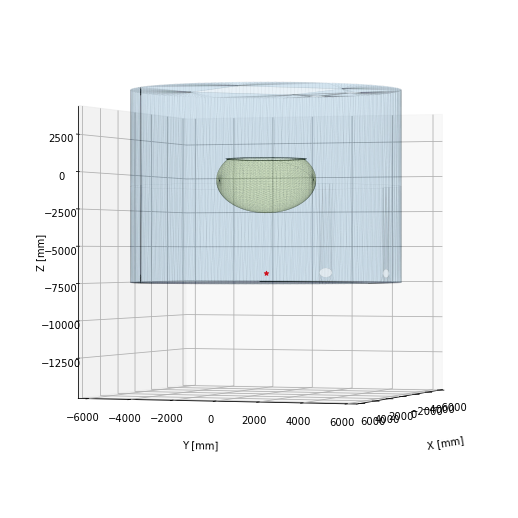

In [10]:
#testing just the geometry

fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)
   
addGeometry(axes, parts=['OC','WT']) 
axes.scatter3D(0, 0, -6860.00+centerShift[2], marker='*', color='r') #should be the bottom of the WT

# axes.set_xlim3d(-100, 100)
# axes.set_ylim3d(-100, 100)
# axes.set_zlim3d(-8000, -6730)

axes.set_xlim3d(-6200, 6200)
axes.set_ylim3d(-6200, 6200)
axes.set_zlim3d(-14800, 4030)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 20)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()